
## **Question : 1** 


 **Linear Least Squares** **[5 points]**


The simplest model to predict the spread of infectious diseases is the SIR model. This model is a set of ordinary differential equations that describe the evolution of the number of susceptible (S(t)), infected (I(t)) and recovered/removed (R(t)) populations in a closed system. The equations are

$\frac{dS}{dt} = \frac {−βIS} {N} $, (1)

$\frac{dI}{dt} =\frac {βIS} {N} −γI$, (2)

$\frac{dR}{dt} = γI$, (3)

where $N = S(t)+I(t)+R(t)$. The basic reproduction number $R_0 = β/γ$ is defined to quantify the new infections that one infected person causes and is considered as a magic number to identify if an infectious disease is under control. For example, if $R_0 > 1$, the disease has an exponential growth whereas if $R_0 < 1$, the disease is under control and the infectious population will eventually go to zero. At peak $R_0$ will cross 1.
As with simple models, there exist analytical solutions to the SIR model. One form of the solution is given as

$S(t) = S(0) exp(−χ(t))$ , (4)

$I(t) = N − S(t) − R(t)$ , (5)

$R(t) = R(0) + ρχ(t)$ , (6)

$χ(t) = \frac {β} {N} \int_{0}^{t}I(t^*) dt^*$. (7)


For this assignment, we will consider a time unit of days, total population of India as 130 crores and the time horizon of interest as March 23, 2020 to Oct 15, 2020. Removed is a sum of recovered and deceased, i.e., the population that will not get infected again. Data in CSV form for state-wise-daily is available at
https://data.covid19india.org/csv/latest/state_wise_daily.csv

1. Download the state wise daily data of infected, recovered and deceased from the covid19india website. The data gives daily new infections, recovery and deceased. Use Pandas and create time-series of all India $I(t), S(t)$ and $R(t)$. Plot these time- series. Hint: Apply yourself and see what $I(t)$ means and what the data provides.
2. Formulate the problem of estimating $γ$ and $β$ as a linear least squares problem.
3. Form the Jacobian matrix and calculate its rank and condition number.
4. Form the coefficient matrix and calculate its condition number. Find the relation between this condition number and condition number of the Jacobian.
5. Code the cholesky factorization approach to solve the linear least squares problem.
6. Apply your code and estimate $β, γ$ and $R_0$.
7. Use scipy.optimize and estimate $β, γ$ and $R_0$.
8. State your observations in the above two items and give reasons.
9. Estimate $R_0(t)$ as a function of time by utilizing data until t to estimate the different parameters. Plot $R_0(t)$. 
10. Based on the above analyse the state of the pandemic in India. Has the peak passed as on Oct 2020?

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./data/state_wise_daily.csv')
summed_data = df.sum(axis=1,numeric_only=True)   # Sum up along rows

#### Formula Used

- S(1) = Initial_population - Infected count from csv on day 1
- R(1) = Recovered count from csv on day 1
- I(1) = Infected count from csv on day 1 - R(1)

Further on
- S(t) = S(t-1) - Infected count from csv on day t
- R(t) = R(t-1) + Recovered count from csv on day t
- I(t) = I(t-1) + ( Infected count from csv on day t - Recovered count on day t)

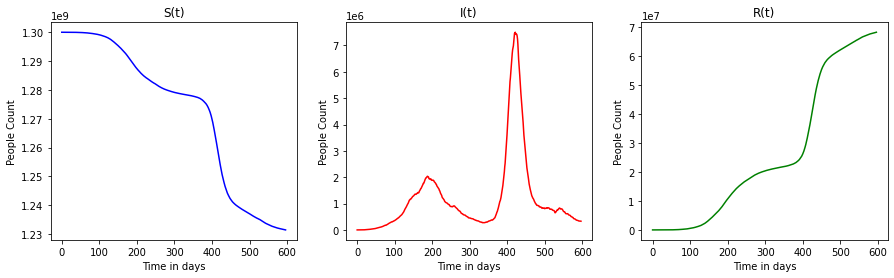

In [7]:
def get_susceptible_infected_recovered(data_frame):
    
    POPULATION = 130 * (10**7)
    
    infected_indices = [3*i for i in range(int(len(data_frame)/3))]
    recovered_indices = [ 3*i+1 for i in range(int(len(data_frame)/3)) ]  # Add indices of Recovered
    recovered_indices =  recovered_indices +  [ 3*i+2 for i in range(int(len(data_frame)/3)) ] # Add indices of Decesesed
    recovered_indices = sorted(recovered_indices) 

    recovered_deceased = summed_data[recovered_indices]  # Get only rows related to recovered and deceased
    recovered_dup = recovered_deceased.groupby(recovered_deceased.index//3).transform('sum')
    rec_indices = [ 3*i + 1 for i in range(int(len(recovered_dup)//2))]
    

    recovered = recovered_dup[rec_indices]
    recovered = recovered.reset_index(drop = True)
    infected = summed_data[infected_indices]
    infected = infected.reset_index(drop=True)

    new_dataframe = pd.DataFrame({'infected' :  infected , 'recovered' : recovered})
    time_series = new_dataframe.index.array



    time_series_df = pd.DataFrame()
    time_series_df.insert(0,"time",time_series)
    time_series_df["S(t)"] = 0
    time_series_df["I(t)"] = 0
    
    time_series_df.insert(3,"R(t)",new_dataframe['recovered'].cumsum()) # R(t) increases as more people recover each day So taking cumulative sum

    time_series_df.loc[0,"S(t)"] = POPULATION- new_dataframe.loc[0,'infected'] # Infected people will only get deducted from susceptible
    time_series_df.loc[0,"I(t)"] = new_dataframe.loc[0,'infected'] - new_dataframe.loc[0,'recovered'] # Formuala derived from I(t) = N - S(t) - R(t)
    
    # Continue for all timesteps
    for i in range(1,len(new_dataframe)):
    
        time_series_df.loc[i,"S(t)"] = time_series_df.loc[i-1,"S(t)"] - new_dataframe.loc[i,'infected']
        time_series_df.loc[i,"I(t)"] = time_series_df.loc[i-1,"I(t)"] + (new_dataframe.loc[i,'infected'] - new_dataframe.loc[i,'recovered'])
    return time_series_df


# To plot the time series graph for infected recovered and deceased.
def plot_time_series(data_frame):

    def set_axis_title(ax,title):
        ax.set_ylabel('People Count')
        ax.set_xlabel('Time in days')
        ax.set_title(title)

    figure,axes = plt.subplots(1,3)
    figure.set_figwidth(15)

    axes[0].plot(time_series_df['time'],time_series_df['S(t)'] ,color='b', label = 'S(t)')
    axes[1].plot(time_series_df['time'],time_series_df['I(t)'] ,color='r', label = 'I(t)')
    axes[2].plot(time_series_df['time'],time_series_df['R(t)'] ,color='g', label = 'R(t)')
    set_axis_title(axes[0],'S(t)')
    set_axis_title(axes[1],'I(t)')
    set_axis_title(axes[2],'R(t)')
    plt.show()



time_series_df = get_susceptible_infected_recovered(summed_data)
plot_time_series(time_series_df)

#### Least Square Problem Formulation

- We will be considering the case of a particular day t
- $\beta(t)$ and $\gamma(t)$ are the unknown parameters
- $dS/dt$ , $dI/dt$ and $dR/dt$ can be estimated using the central difference method whose general form is
   <br> <br> $\frac{\partial f(t)}{dt} = \frac{f(t+1) - f(t-1)}{2}$

- Edge cases handled by taking forward difference only and vice versa

The least squares formulation would be

<br> <br>
$$
\left[\begin{array}{cc} 
-\frac{I(t)*S(t)}{N} & 0\\ \\
\frac{I(t)*S(t)}{N} & -I(t) \\ \\
0 & I(t) \\
\end{array}\right]
\left[\begin{array}{c} 
\beta \\
\gamma
\end{array}\right]
= 
\left[\begin{array}{c} 
\frac{dS(t)}{dt}\\ \\
\frac{dI(t)}{dt} \\ \\
\frac{dR(t)}{dt}
\end{array}\right]
$$ 


### Jacobian




The vector valued function is 
    $$f(\left[ \begin{array}{c} 
    \beta \\
    \gamma
    \end{array} \right]) = \left[\begin{array}{c} 
\frac{dS(t)}{dt}\\ \\
\frac{dI(t)}{dt} \\ \\
\frac{dR(t)}{dt}
\end{array}\right] = \left[\begin{array}{c} 
\frac {−βIS} {N} \\ \\
\frac {βIS} {N} −γI \\ \\
γI
\end{array}\right] = \left[\begin{array}{c} 
f_1\\ \\
f_2 \\ \\
f_3
\end{array}\right]$$  

Calculating the Jacobian Matrix
$$ J = \left[\begin{array}{cc} 
\frac{df_1(t)}{d\beta} & \frac{df_1(t)}{d\gamma} \\ \\
\frac{df_2(t)}{d\beta} & \frac{df_2(t)}{d\gamma} \\ \\
\frac{df_3(t)}{d\beta} & \frac{df_3(t)}{d\gamma}
\end{array}\right] = \left[\begin{array}{cc} 
-\frac{I*S}{N} & 0\\ \\
\frac{I*S}{N} & -I \\ \\
0 & I \\
\end{array}\right]$$ 

The jacobian matrix is equivalent to the coefficient matrix which we used for the formulating the least squares problem.